### Simple input LIF model with integer values only

In [1]:
import sys
#sys.path.append('/home/jovyan/brian2lava')
#sys.path.append('/home/carlo/Entwicklung/Python/brian2lava')
#sys.path.append('/home/francesco/Developing/B2L/brian2lava')
#sys.path.append('/homes/jlubo/brian2lava')

In [2]:
from brian2 import *

In [3]:
# Import Brian2Lava
import brian2lava

# Use included models directory
# models_dir=None

# Use external models directory (containing ncProcessModels for Loihi)
models_dir='/homes/jlubo/brian2lava-models/models'
#models_dir='/homes/francesco.negri/B2L/brian2lava-models/models'

# Use external processes library (for Lava-Loihi/Loihi 2 hardware)
lava_proc_dir = "/homes/jlubo/brian2lava-models/lava_proc"

# Set device, choosing Loihi 2 with fixed-point representation, but switching off F2F conversion
set_device('lava', mode='preset', hardware='Loihi2', num_repr='fixed', use_f2f=False, models_dir=models_dir, lava_proc_dir=lava_proc_dir, variable_updating_disabled=False)
BrianLogger.log_level_debug()

WARNING    The name of one (or more) models defined in the given model directory '/homes/jlubo/brian2lava-models/models' already exists in Brian2Lava's standard model library. Note that user-defined models will always override standard models. If you do not want this to happen, rename your model folder(s). [brian2lava.preset_mode.model_loader]


In [4]:
# Import LIF model
from brian2lava.preset_mode.model_loader import lif

In [5]:
# Set seed
seed(1)

# Set defaultclock
defaultclock.dt = 1 * second #0.5*ms

In [6]:
print(lif.equations, type(lif.equations))
print(lif.conditions)

dj/dt = -j/tau_j : V/s
dv/dt = -v/tau_v + j + bias : V
bias : V/s <class 'brian2.equations.equations.Equations'>
{'th': 'v > v_th', 'rs': 'v = v_rs'}


Model name (name of the Lava process)                                           
--------------------------------------------------------------------------------
lif                                                                             


Description                                                                     
--------------------------------------------------------------------------------
Leaky Integrate-and-Fire neuron with exponentially decaying current input       


Model equations (rendered LaTeX)                                                
--------------------------------------------------------------------------------


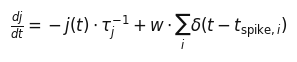

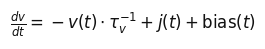

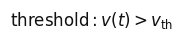

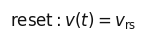



Brian 2 equations                                                               
--------------------------------------------------------------------------------
dj/dt = -j/tau_j : volt/second                                                  
dv/dt = -v/tau_v + j + bias : volt                                              
bias : volt/second                                                              


Brian 2 conditions                                                              
--------------------------------------------------------------------------------
th : v > v_th                                                                   
rs : v = v_rs                                                                   


Refractory period                                                               
--------------------------------------------------------------------------------
<not supported>


Variables                                                                       
----

In [7]:
lif.show()

In [8]:
# Value for model scaling
scf = 1000

# Define parameters
N = 3
bias = 0.015 * scf * mV/ms
tau_j = 0 * scf * ms
tau_v = 10 * scf * ms
v_th = 100 * scf * mV
v_rs = -5 * scf * mV
t_rp = 0 * scf * ms

# Add a spike generator group
S = SpikeGeneratorGroup(N, [0, 0], [2, 6]*second) # <--- only works with N neurons!

# Add a neuron group (which receives a background input)
P = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='t_rp', method='euler')
P.j = "0.0 * scf * mV/ms"
P.bias = bias
P.v = "2 * scf * mV"

# Add another neuron group (which does not receive a background input)
Q = NeuronGroup(N, lif.equations, threshold=lif.conditions["th"], reset=lif.conditions["rs"], refractory='t_rp', method='euler')
#Q.j = "0.1*mV/ms"
Q.bias = bias
Q.v = "2 * scf * mV"

# Add synapses
syn = Synapses(S, Q, model = 'w : volt/second', on_pre='j_post += w')
syn.connect(i=[0], j=[0,1,2])
syn.w = 1.0 * scf * mV/second

DEBUG      Creating synapses from group 'spikegeneratorgroup' to group 'neurongroup_1', using pre-defined arrays) [brian2.synapses.synapses]


In [9]:
device = get_device()
device.code_object_class()

brian2.codegen.runtime.numpy_rt.numpy_rt.NumpyCodeObject

In [10]:
# Add monitor for spikes
spmP = SpikeMonitor(P, variables='v', record=[0])
spmQ = SpikeMonitor(Q, variables='v', record=True)

# Add monitors for voltage and current
stmPv = StateMonitor(P, variables='v', record=True)
stmPj = StateMonitor(P, variables='j', record=True)
stmQv = StateMonitor(Q, variables='v', record=True)
stmQj = StateMonitor(Q, variables='j', record=True)
# spkmP = SpikeMonitor(P)

WARNING    [EFFICIENCY]: Recording specific indices is not supported by Lava natively. In Brian2Lava, the specified 
        indices are only considered when using spike monitors on Loihi 2 (this is an additional feature compared to Brian 2, 
        where the 'record' parameter only accepts boolean values). Otherwise, all elements are monitored regardless of the 
        specified indices, and filtering is done only as a post-processing step - thus, no performance gain will come from it. [brian2.devices.lava]
WARNING    [EFFICIENCY]: Recording specific indices is not supported by Lava natively. In Brian2Lava, the specified 
        indices are only considered when using spike monitors on Loihi 2 (this is an additional feature compared to Brian 2, 
        where the 'record' parameter only accepts boolean values). Otherwise, all elements are monitored regardless of the 
        specified indices, and filtering is done only as a post-processing step - thus, no performance gain will come

In [11]:
# Run simulation
#run(15*ms)
run(30 * second)

DEBUG      Updated MagicNetwork to include 17 objects with names spikegeneratorgroup, neurongroup_1_spike_resetter, synapses, neurongroup_1_spike_thresholder, synapses_pre, neurongroup_spike_resetter, neurongroup, neurongroup_stateupdater, spikemonitor, statemonitor_2, neurongroup_1, spikemonitor_1, statemonitor_1, neurongroup_1_stateupdater, neurongroup_spike_thresholder, statemonitor_3, statemonitor [brian2.core.magic.magic_objects]
DEBUG      Preparing network 'magicnetwork' with 17 objects: neurongroup, neurongroup_1, statemonitor, statemonitor_1, statemonitor_2, statemonitor_3, synapses, neurongroup_1_stateupdater, neurongroup_stateupdater, neurongroup_1_spike_thresholder, neurongroup_spike_thresholder, spikegeneratorgroup, spikemonitor, spikemonitor_1, synapses_pre, neurongroup_1_spike_resetter, neurongroup_spike_resetter [brian2.core.network.before_run]
DEBUG      Group neurongroup_1: using numerical integration method euler (took 0.01s) [brian2.stateupdaters.base.method_choice]

ucode_neuron cmd='/homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/ucode_compiler/bin/dend_asm /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.cpp /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.ucb > /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.dat 2> /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup_1.err'


DEBUG      self.indices = [0 1 2] [brian2.devices.lava]
DEBUG      Added program with index 0 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Added program with index 1 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Added program with index 2 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Saved spike series to /homes/jlubo/brian2lava-models/models/lava_workspace/_spike_spikemonitor_1_spikes_series.npy [brian2.devices.lava]
DEBUG      Running process: neurongroup, <class 'lava_workspace.Loihi2_preset_neurongroup.LIF'> [brian2.devices.lava]
DEBUG      Process 'neurongroup' initialized with NcL2ModelLif process model [brian2.devices.lava]


ucode_neuron cmd='/homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/ucode_compiler/bin/dend_asm /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.cpp /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.ucb > /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.dat 2> /homes/jlubo/lava/lava_nx_env_0.7.0/lib/python3.10/site-packages/lava/magma/compiler/subcompilers/nc/neurocore/n3/programs/tmp/Loihi2_preset_neurongroup.err'


DEBUG      self.indices = [0] [brian2.devices.lava]
DEBUG      Added program with index 0 on nx core 2052, processor core 405, group 0... [brian2.devices.lava]
DEBUG      Saved spike series to /homes/jlubo/brian2lava-models/models/lava_workspace/_spike_spikemonitor_spikes_series.npy [brian2.devices.lava]
DEBUG      Successfully run simulation [brian2.devices.lava]
INFO       Retrieving monitor values [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.s_out' (N_tot = 1) [brian2.devices.lava]
DEBUG      Retrieving spike series from /homes/jlubo/brian2lava-models/models/lava_workspace/_spike_spikemonitor_spikes_series.npy [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.v' (N_tot = 3) [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.v' (N_tot = 3) [brian2.devices.lava]
DEBUG      Got data from state probe referring to 'neurongroup.j' (N_tot = 3) [brian2.devices.lava]
DEBUG      Got da

In [12]:
# #stm2.variables['v'].get_value()
print(f"P.v = {P.v/scf}")
print(f"P.j = {P.j/scf}")
print(f"Q.v = {Q.v/scf}")
print(f"Q.j = {Q.j/scf}")
#print(f"stmPv.t =\n{stmPv.t}")
#print(f"stmPv.v =\n{stmPv.v}")
#print(f"stmPj.j =\n{stmPj.j}")
#print(f"stmQv.v =\n{stmQv.v}")
#print(f"stmQj.j =\n{stmQj.j}")
print("NOTE: these values have not been updated since the beginning of the simulation (due to 'variable_updating_disabled=True').")

P.v = [66. 66. 66.] mV
P.j = [0. 0. 0.] V/s
Q.v = [74. 74. 74.] mV
Q.j = [0. 0. 0.] V/s
NOTE: these values have not been updated since the beginning of the simulation (due to 'variable_updating_disabled=True').


In [13]:
spmP.i

<spikemonitor.i: array([0, 0])>

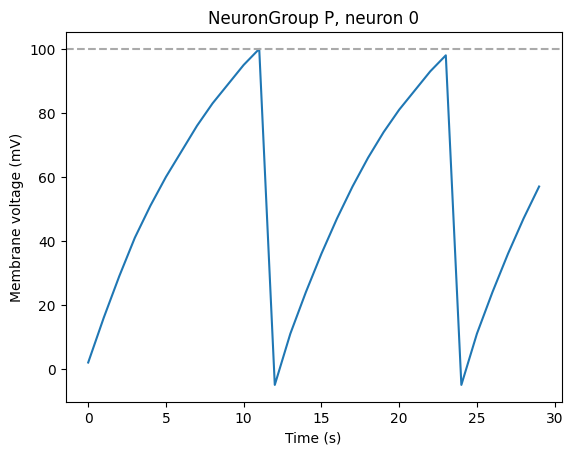

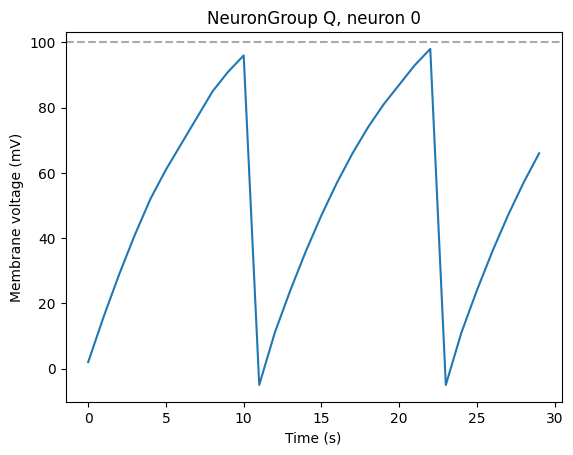

In [14]:
plt.plot(stmPv.t/second,stmPv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup P, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
show()

plt.plot(stmQv.t/second,stmQv.v[0]/mV/scf)
plt.axhline(v_th/mV/scf, linestyle="dashed", color="#aaaaaa", label='Threshold')
title('NeuronGroup Q, neuron 0')
xlabel('Time (s)')
ylabel('Membrane voltage (mV)')
show()

In [15]:
print("NeuronGroup P:")
print(f"  {len(spmP.i)} spikes occurred in neuron 0.")
print("  ", spmP.t[spmP.i == 0])
print("  ", spmP.v[spmP.i == 0])
print("NeuronGroup Q:")
print(f"  {len(spmQ.i)} spikes occurred in total, {np.sum(spmQ.i == 0)} in neuron 0.")
print("  ", spmQ.t[spmQ.i == 0])
print("  ", spmQ.v[spmQ.i == 0])

NeuronGroup P:
  2 spikes occurred in neuron 0.
   [11. 23.] s
   [100.  98.] V
NeuronGroup Q:
  6 spikes occurred in total, 2 in neuron 0.
   [10. 22.] s
   [96. 98.] V
